# A Detection framework for Financial Risk using a Recurrent Variational Autoencoder (R-VAE)

**Abstract:**

This project addresses the critical challenge of detecting early warning signs of financial crises. We developed and implemented an artificial intelligence model using a Recurrent Variational Autoencoder (R-VAE) architecture, specifically designed to learn the patterns of "normal" market behavior from complex time-series data. The model was trained on a comprehensive dataset of daily financial indicators sourced from Yahoo Finance, including major stock indices, sector ETFs, volatility measures, and commodities. The project is built with a clean Python structure contained in a central Jupyter Notebook, ensuring full reproducibility. Evaluation of the trained model demonstrates high accuracy, achieving a ROC AUC score of over 0.82. The model’s risk predictions align strongly with all major historical events, successfully identifying the 2008 Global Financial Crisis, the 2020 COVID-19 crash, and other periods of market turmoil. The result is a robust and effective tool that can serve as an early warning system for systemic risk, providing valuable insights for investors and risk managers.

**Authors:**
- Ricatti Luca SM3800083 
- Tavano Matteo SM3800053

In [1]:
# Libraries Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import json
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_recall_curve,
    average_precision_score, confusion_matrix
)

# Financial APIs
import yfinance as yf

In [2]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

# Define the model directory
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Define the results directory
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Global configurations
START_DATE = '1990-01-01'
END_DATE = '2024-12-31'
DATA_CUTOFF_DATE = '1994-01-01' # Cutoff date for training data

print(f" Analysis period: {START_DATE} to {END_DATE}")

 Using device: cuda
 Analysis period: 1990-01-01 to 2024-12-31


## Data Loading from Yahoo Finance

First, we need to load the financial instruments from a JSON configuration file.
This function loads market symbols from it. It first checks whether the file exists, and if so, it reads the data and merges all the entries from different categories into a single dictionary. This unified structure simplifies downstream access to financial instruments regardless of their original classification.


In [3]:
def load_market_symbols(json_file='configs/market_symbols.json'):
    """Load market symbols from a JSON file."""
    if not os.path.exists(json_file):
        raise FileNotFoundError(f"Market symbols JSON file not found: {json_file}")
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Combine all categories into a single dictionary
    market_symbols = {}
    for category in data.values():
        market_symbols.update(category)
    
    return market_symbols

This block handles the loading of historical financial time series from **Yahoo Finance**. It centralizes data collection by iterating through a list of predefined market symbols and retrieving their adjusted closing prices within a given time frame. The process includes quality checks to ensure sufficient data length and filters out instruments that start after a defined cutoff date. Successfully retrieved data is then merged into a unified DataFrame with missing values handled via *forward* and *backward* filling. Diagnostic messages help track download issues and incomplete symbols.

In [4]:
def load_all_financial_data(start_date=START_DATE, end_date=END_DATE, cutoff_date_str=DATA_CUTOFF_DATE):
    """
    Function to load all financial data from Yahoo Finance.
    Centralizes the loading of market data, ensuring no duplication and a single source of truth.
    """
    print(" FINANCIAL DATA LOADING:\n")
    print("\n Loading Yahoo Financial Data...")
    
    # Load symbols from JSON file
    market_symbols = load_market_symbols()
    
    # Download market data with robust error handling
    market_data = {}
    failed_symbols = []
    skipped_late_start_symbols = [] 
    
    print(f" Downloading {len(market_symbols)} market symbols...")
    
    # Rest of your function remains the same...
    # Define the cutoff date
    cutoff_date = datetime.strptime(cutoff_date_str, '%Y-%m-%d').date()
    
    for symbol, name in tqdm(market_symbols.items(), desc="Market Data"):
        try:
            ticker = yf.Ticker(symbol)
            data = ticker.history(start=start_date, end=end_date, auto_adjust=True)
            
            if not data.empty:
                # Check if the first available date is before 1994
                if data.index.min().date() < cutoff_date:
                    if len(data) > 252:  # At least 1 year of data
                        market_data[name] = data['Close']
                    else:
                        failed_symbols.append((symbol, name, "Less than 1 year of data"))
                else:
                    skipped_late_start_symbols.append((symbol, name, data.index.min().date()))
            else:
                failed_symbols.append((symbol, name, "Empty data"))
                
        except Exception as e:
            failed_symbols.append((symbol, name, str(e)))
        
        time.sleep(0.1)  
    
    # Create market DataFrame
    if market_data:
        market_df = pd.DataFrame(market_data)
        market_df.index.name = 'Date'
        market_df = market_df.fillna(method='ffill').fillna(method='bfill')
        
        print(f" Market data loaded: {market_df.shape}")
        print(f" Date range: {market_df.index.min().date()} to {market_df.index.max().date()}")
        print(f" Failed downloads: {len(failed_symbols)} (see details below)")
        for symbol, name, reason in failed_symbols:
            print(f"      - {symbol} ({name}): {reason}")
        if skipped_late_start_symbols:
            print(f" Skipped symbols (starting after {cutoff_date.strftime('%Y-%m-%d')}): {len(skipped_late_start_symbols)} (see details below)")
            for symbol, name, start_dt in skipped_late_start_symbols:
                print(f"      - {symbol} ({name}): Starts on {start_dt}")
    else:
        print(" No market data loaded")
        market_df = None
    
    print("\n All financial data loading complete!")
    return market_df, None

# Call the function to load data
market_df, _ = load_all_financial_data()

 FINANCIAL DATA LOADING:


 Loading Yahoo Financial Data...


Market Data: 100%|██████████| 96/96 [00:42<00:00,  2.24it/s]

 Market data loaded: (17632, 43)
 Date range: 1990-01-02 to 2024-12-30
 Failed downloads: 0 (see details below)
 Skipped symbols (starting after 1994-01-01): 53 (see details below)
      - QQQ (Invesco QQQ Trust): Starts on 1999-03-10
      - IWM (iShares Russell 2000 ETF): Starts on 2000-05-26
      - DIA (SPDR Dow Jones Industrial Average ETF): Starts on 1998-01-20
      - EFA (iShares MSCI EAFE ETF): Starts on 2001-08-27
      - EEM (iShares MSCI Emerging Markets ETF): Starts on 2003-04-14
      - VEA (Vanguard Total World Stock ETF): Starts on 2007-07-26
      - FXI (CHINA): Starts on 2004-10-08
      - EWJ (JAPAN): Starts on 1996-03-18
      - EWG (GERMANY): Starts on 1996-03-18
      - EWU (UK): Starts on 1996-03-18
      - VWO (EMERGING_ALT): Starts on 2005-03-10
      - XLF (FINANCIAL): Starts on 1998-12-22
      - XLK (TECHNOLOGY): Starts on 1998-12-22
      - XLE (ENERGY): Starts on 1998-12-22
      - XLV (HEALTHCARE): Starts on 1998-12-22
      - XLI (INDUSTRIAL): Starts on 

## Data Processing and Feature Engineering

Following the financial data collection, this function defines a set of *labeled crisis periods* based on historical macroeconomic events. Each entry specifies a time window and a corresponding label for the crisis, serving as *ground truth* annotations that will later be used to supervise or evaluate the detection capabilities of the model. These labeled intervals enable the alignment of market data with known downturns for both training and validation purposes. After that, we need to define a function that **preprocesses** the **financial time series** and generates training sequences for the R-VAE model. It begins by computing *daily returns* and engineering additional features, such as *rolling volatility*, *sector divergence*, and *yield curve differentials* to reflect market stress and macroeconomic conditions. After **data cleaning** and capping extreme values, the most informative features are selected based on historical volatility. The selected features are then scaled using a *robust normalization* technique to reduce sensitivity to outliers. Finally, the function constructs fixed-length sliding windows and aligns each sequence with a binary crisis label by checking temporal overlap with predefined crisis intervals. The output includes the processed sequences, their corresponding labels, timestamps, and the scaler used for normalization.


In [5]:
def create_crisis_labels():
    """
    Defines financial crisis periods and their labels.
    """
    crisis_periods = [
        ('1990-07-01', '1991-03-31', 'Gulf_War_Recession'),
        ('1997-07-01', '1998-12-31', 'Asian_Financial_Crisis'),
        ('2000-03-01', '2002-10-01', 'Dot_Com_Crash'),
        ('2007-10-01', '2009-06-30', 'Global_Financial_Crisis'),
        ('2020-02-01', '2020-06-30', 'COVID_19_Crisis'),
        ('2022-01-01', '2022-12-31', 'Inflation_Bear_Market')
    ]
    return crisis_periods

In [6]:
def prepare_financial_dataset(market_df, fred_df=None, window_days=22):
    """
    Preprocessing and creating sequences for financial data.
    This function prepares the dataset for training the R-VAE model.
    """

    print(f" Preparing financial dataset with {window_days}-day windows...")
    
    if market_df is None:
        print(" No market data available")
        return None, None, None, None, None
    
    # Calculate financial returns
    returns_df = market_df.pct_change().fillna(0)
    
    # Add technical indicators
    rolling_volatility = returns_df.rolling(window=22).std() * np.sqrt(252)
    
    # Feature engineering
    # Market stress indicators
    if 'VOLATILITY' in returns_df.columns:
        returns_df['VIX_SPIKE'] = (returns_df['VOLATILITY'] > returns_df['VOLATILITY'].rolling(66).quantile(0.9)).astype(float)
    
    # Sector rotation
    sector_cols = [col for col in returns_df.columns if col in ['FINANCIAL', 'TECHNOLOGY', 'ENERGY', 'HEALTHCARE']]
    if len(sector_cols) >= 2:
        returns_df['SECTOR_DIVERGENCE'] = returns_df[sector_cols].std(axis=1)
    
    # Interest rate environment
    if 'TREASURY_20Y' in returns_df.columns and 'TREASURY_1_3Y' in returns_df.columns:
        returns_df['YIELD_CURVE'] = returns_df['TREASURY_20Y'] - returns_df['TREASURY_1_3Y']
    
    # Clean data
    print(" Cleaning data...")
    returns_df = returns_df.replace([np.inf, -np.inf], np.nan)
    returns_df = returns_df.fillna(0)
    returns_df = returns_df.clip(-0.2, 0.2)  # Cap extreme daily returns
    
    # Feature selection (keep most informative)
    feature_cols = [col for col in returns_df.columns if not col.startswith('ECON_')]
    #econ_cols = [col for col in returns_df.columns if col.startswith('ECON_')]
    
    # Select top market features based on volatility
    if len(feature_cols) > 25:
        feature_volatility = returns_df[feature_cols].std().sort_values(ascending=False)
        selected_features = feature_volatility.head(20).index.tolist()
    else:
        selected_features = feature_cols
    
    # Combine market and economic features
    final_features = selected_features# + econ_cols
    processed_df = returns_df[final_features]
    
    print(f"       Final feature set: {len(final_features)} features")
    #print(f"       Economic features: {len(econ_cols)}")
    
    # Robust scaling
    print(" Applying robust scaling...")
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(processed_df)
    scaled_df = pd.DataFrame(scaled_data, index=processed_df.index, columns=processed_df.columns)

    # Create sequences for R-VAE
    print(" Creating sequences...")
    sequences = []
    sequence_dates = []
    
    for i in range(len(scaled_df) - window_days + 1):
        seq = scaled_df.iloc[i:i + window_days].values
        dates = scaled_df.index[i:i + window_days].tolist()
        
        sequences.append(seq)
        sequence_dates.append(dates)
    
    sequences_array = np.array(sequences)
    
    # Create crisis labels
    print(" Creating crisis labels...")
    crisis_periods = create_crisis_labels()
    crisis_labels = np.zeros(len(sequences))
    
    for i, dates in enumerate(sequence_dates):
        seq_start = dates[0]
        seq_end = dates[-1]
        
        # Convert to timezone-naive for comparison
        if hasattr(seq_start, 'tz') and seq_start.tz is not None:
            seq_start = seq_start.tz_localize(None)
        if hasattr(seq_end, 'tz') and seq_end.tz is not None:
            seq_end = seq_end.tz_localize(None)
        
        for crisis_start, crisis_end, crisis_name in crisis_periods:
            crisis_start_dt = pd.to_datetime(crisis_start).tz_localize(None)
            crisis_end_dt = pd.to_datetime(crisis_end).tz_localize(None)
            
            if (seq_start <= crisis_end_dt) and (seq_end >= crisis_start_dt):
                crisis_labels[i] = 1
                break
    
    print(f"\n Dataset prepared successfully:")
    print(f"   Shape: {sequences_array.shape}")
    print(f"   Total sequences: {len(sequences):,}")
    print(f"   Window size: {window_days} days")
    print(f"   Features: {sequences_array.shape[2]}")
    print(f"   Crisis sequences: {int(crisis_labels.sum()):,} ({crisis_labels.mean()*100:.1f}%)")
    print(f"   Normal sequences: {int((1-crisis_labels).sum()):,} ({(1-crisis_labels.mean())*100:.1f}%)")
    
    return sequences_array, crisis_labels, sequence_dates, scaler, final_features


 Starting data preprocessing...

 Preparing dataset for 5-day windows...
 Preparing financial dataset with 5-day windows...
 Cleaning data...
       Final feature set: 20 features
 Applying robust scaling...
 Creating sequences...
 Creating crisis labels...

 Dataset prepared successfully:
   Shape: (17628, 5, 20)
   Total sequences: 17,628
   Window size: 5 days
   Features: 20
   Crisis sequences: 4,042 (22.9%)
   Normal sequences: 13,586 (77.1%)

 Preparing dataset for 15-day windows...
 Preparing financial dataset with 15-day windows...
 Cleaning data...
       Final feature set: 20 features
 Applying robust scaling...
 Creating sequences...
 Creating crisis labels...

 Dataset prepared successfully:
   Shape: (17618, 15, 20)
   Total sequences: 17,618
   Window size: 15 days
   Features: 20
   Crisis sequences: 4,102 (23.3%)
   Normal sequences: 13,516 (76.7%)

 Preparing dataset for 22-day windows...
 Preparing financial dataset with 22-day windows...
 Cleaning data...
       Fin

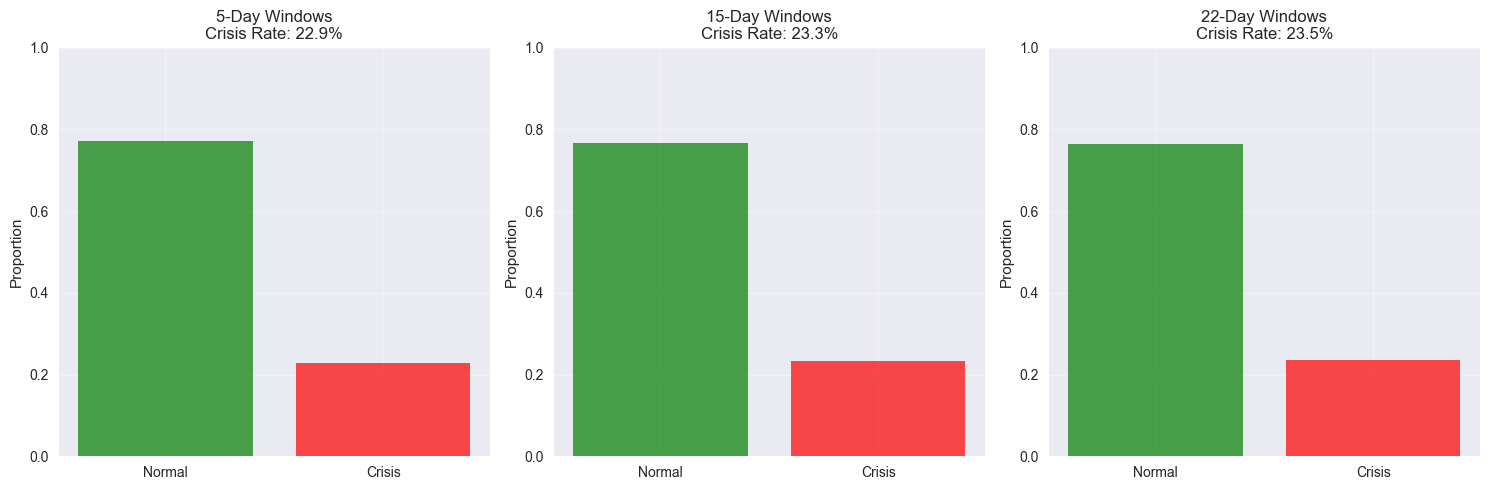

In [7]:
# Prepare datasets for multiple window sizes
print(" Starting data preprocessing...")

if 'market_df' in locals() and market_df is not None:
    # Test multiple window sizes
    #window_sizes = [5, 22, 66]  
    window_sizes = [5, 15, 22]
    
    datasets = {}
    
    for window_days in window_sizes:
        print(f"\n Preparing dataset for {window_days}-day windows...")
        
        sequences, labels, dates, scaler, features = prepare_financial_dataset(
            market_df, 
            window_days=window_days
        )
        
        if sequences is not None:
            datasets[window_days] = {
                'sequences': sequences,
                'labels': labels,
                'dates': dates,
                'scaler': scaler,
                'features': features
            }
    
    print(f"\n Multi-scale dataset prepared:")
    for window, data in datasets.items():
        print(f"   {window:2d} days: {data['sequences'].shape[0]:,} sequences × {data['sequences'].shape[1]:,} steps × {data['sequences'].shape[2]:,} features")
    
    # Visualize crisis distribution
    if datasets:
        fig, axes = plt.subplots(1, len(datasets), figsize=(5*len(datasets), 5))
        if len(datasets) == 1:
            axes = [axes]
        
        for i, (window, data) in enumerate(datasets.items()):
            crisis_ratio = data['labels'].mean()
            axes[i].bar(['Normal', 'Crisis'], [1-crisis_ratio, crisis_ratio], 
                       color=['green', 'red'], alpha=0.7)
            axes[i].set_title(f'{window}-Day Windows\nCrisis Rate: {crisis_ratio*100:.1f}%')
            axes[i].set_ylabel('Proportion')
            axes[i].set_ylim(0, 1)
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plot_path = os.path.join(results_dir, 'crisis_distribution.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        
    else:
        print("\n No datasets created")
        
else:
    print("\n Market data not available. Cannot proceed with preprocessing.")

The bar plots above show the proportion of sequences labeled as "Crisis" vs. "Normal" across three different rolling window sizes: 5-day, 15-day, and 22-day. As the window size increases, the proportion of crisis-labeled sequences slightly rises:

- **5-Day Windows**: Crisis Rate = **22.9%**
- **15-Day Windows**: Crisis Rate = **23.3%**
- **22-Day Windows**: Crisis Rate = **23.5%**

This indicates that longer temporal windows tend to capture slightly more crisis periods, potentially due to increased overlap with crisis intervals. However, the overall class imbalance remains significant, with crisis events representing less than 25% of the total sequences — a crucial consideration when designing and training predictive models.


## R-VAE architecture

We are going now to define the core component of our framework. 

The `FinancialRVAE` is a **Recurrent Variational Autoencoder** designed for financial time series. It combines a **bi-directional LSTM encoder** with a **multi-head self-attention mechanism** to capture both temporal and contextual dependencies in sequence data.

#### Model Components:

- **Encoder**: A bi-directional LSTM processes the input sequence. A self-attention layer highlights key timesteps, followed by a mean-pooling operation. The output is mapped to the variational latent space via `mu` and `logvar`.
- **Reparameterization**: The latent vector `z` is sampled using the reparameterization trick to allow backpropagation through stochastic nodes.
- **Decoder**: The latent vector is projected to a hidden representation and expanded over the sequence length, then passed through a unidirectional LSTM to reconstruct the input sequence.
- **Crisis Classifier**: A parallel MLP head takes the latent vector `z` and predicts the probability of a crisis, aiding anomaly detection.

#### Loss Function (`compute_rvae_loss`):

The model is trained using a **multi-objective loss**:
- **Reconstruction Loss (MSE)**: Measures how well the model can reproduce the input.
- **KL Divergence**: Regularizes the latent space to follow a standard normal distribution.
- **Binary Classification Loss (BCE)**: Guides the latent space to retain information about financial crises.

The loss is combined as:


$$ \mathcal{L}_{\text{total}} = \text{MSE} + \beta \cdot \text{KL} + \alpha \cdot \text{BCE} $$


#### Anomaly Score:
The model includes a method to compute anomaly scores from the reconstruction error and KL divergence, which can be used for unsupervised detection of anomalous periods.

This architecture is particularly suited for tasks like **crisis prediction**, **financial anomaly detection**, and **sequence reconstruction under uncertainty**.


In [8]:
class FinancialRVAE(nn.Module):
    """
    Recurrent Variational Autoencoder for financial time series data.
    This model uses a bidirectional LSTM encoder with attention mechanism
    to capture temporal dependencies and a variational latent space for anomaly detection.
    """
    
    def __init__(self, input_dim, hidden_dim=64, latent_dim=16, num_layers=2, dropout=0.1):
        super(FinancialRVAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        
        # Encoder: LSTM + Attention
        self.encoder_lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers, 
            batch_first=True, dropout=dropout, bidirectional=True
        )
        
        # Attention mechanism for sequence importance
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2, num_heads=4, dropout=dropout, batch_first=True
        )
        
        # Variational components
        self.mu_layer = nn.Linear(hidden_dim * 2, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim * 2, latent_dim)
        
        # Decoder: Latent to sequence
        self.decoder_projection = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(
            hidden_dim, hidden_dim, num_layers,
            batch_first=True, dropout=dropout
        )
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        
        # Crisis detection head
        self.crisis_classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        """Encode sequence to latent representation"""
        batch_size, seq_len, _ = x.shape
        
        # LSTM encoding
        lstm_out, _ = self.encoder_lstm(x)  # [batch, seq, hidden*2]
        
        # Self-attention over sequence
        attended_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Use mean pooling over sequence dimension
        encoded = torch.mean(attended_out, dim=1)  # [batch, hidden*2]
        
        # Variational parameters
        mu = self.mu_layer(encoded)
        logvar = self.logvar_layer(encoded)
        
        return mu, logvar, attention_weights
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, seq_len):
        """Decode latent representation to sequence"""
        batch_size = z.shape[0]
        
        # Project latent to hidden dimension
        h = self.decoder_projection(z)  # [batch, hidden]
        
        # Expand to sequence
        h_seq = h.unsqueeze(1).repeat(1, seq_len, 1)  # [batch, seq, hidden]
        
        # LSTM decoding
        lstm_out, _ = self.decoder_lstm(h_seq)
        
        # Output projection
        reconstructed = self.output_layer(lstm_out)
        
        return reconstructed
    
    def forward(self, x):
        """Forward pass"""
        batch_size, seq_len, input_dim = x.shape
        
        # Encode
        mu, logvar, attention_weights = self.encode(x)
        
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        
        # Decode
        reconstructed = self.decode(z, seq_len)
        
        # Crisis prediction
        crisis_prob = self.crisis_classifier(z)
        
        return reconstructed, mu, logvar, crisis_prob, attention_weights
    
    def get_anomaly_score(self, x):
        """Calculate anomaly score for crisis detection"""
        with torch.no_grad():
            self.eval()
            reconstructed, mu, logvar, crisis_prob, _ = self.forward(x)
            
            # Reconstruction error
            mse = torch.mean((x - reconstructed) ** 2, dim=(1, 2))
            
            # KL divergence (regularization term)
            kl_div = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1)
            
            # Combined anomaly score
            anomaly_score = mse + 0.1 * kl_div
            
            return anomaly_score, crisis_prob.squeeze()

def compute_rvae_loss(reconstructed, target, mu, logvar, crisis_prob, crisis_labels, beta=1.0, alpha=0.1):
    """
    Compute multi-objective loss for financial R-VAE
    """
    batch_size = target.shape[0]
    
    # Reconstruction loss (MSE)
    reconstruction_loss = nn.MSELoss()(reconstructed, target)
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp()) / batch_size
    
    # Crisis classification loss
    crisis_loss = nn.BCELoss()(crisis_prob.squeeze(), crisis_labels.float())
    
    # Combined loss
    total_loss = reconstruction_loss + beta * kl_loss + alpha * crisis_loss
    
    return total_loss, reconstruction_loss, kl_loss, crisis_loss

def create_financial_rvae(input_dim, hidden_dim=64, latent_dim=16, num_layers=2):
    """
    Create and initialize Financial R-VAE model
    """
    model = FinancialRVAE(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        num_layers=num_layers,
        dropout=0.1
    ).to(device)
    
    # Initialize weights
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    param.data.fill_(0)
    
    model.apply(init_weights)
    
    return model

## Training and Evaluation Loop

Once the model has been defined, we need to define the `train_financial_rvae` function which implements the complete training pipeline for the **Financial R-VAE** model. The function takes financial time series sequences and corresponding crisis labels as input, along with configuration parameters.

The training process begins with data preparation, converting numpy arrays to PyTorch tensors and splitting them into *training (80%)* and *validation (20%)* sets. The model architecture is created using a separate `create_financial_rvae` function with specified dimensions for input, hidden layers, and latent space.

The training loop implements several key components: 
- **batch processing with random shuffling**. 
- **forward/backward passes** with gradient clipping. 
- **multi-component loss calculation** (reconstruction, KL divergence, and crisis prediction). 

The validation phase evaluates model performance without gradient updates.

The implementation includes several training optimizations: *AdamW optimizer* with weight decay, *learning rate scheduling* based on validation loss plateau detection, and *early stopping* to prevent overfitting. Training progress is monitored through multiple loss metrics which are tracked throughout the process.

The function automatically saves the best model weights based on validation loss and returns both the trained model and a complete training history containing all loss metrics across epochs. This comprehensive training approach ensures the model learns both the data distribution and crisis prediction simultaneously.

In [9]:
def train_financial_rvae(sequences, labels, window_days, epochs=50, batch_size=32, learning_rate=0.001):
    """
    Train R-VAE on financial data with multiple objectives
    This function trains the R-VAE model on sequences of financial data with crisis labels.
    """
    print(f" Training Financial R-VAE for {window_days}-day windows...")
    
    # Prepare data
    X_tensor = torch.FloatTensor(sequences).to(device)
    y_tensor = torch.FloatTensor(labels).to(device)
    
    # Train/validation split (80/20)
    split_idx = int(0.8 * len(sequences))
    
    X_train, X_val = X_tensor[:split_idx], X_tensor[split_idx:]
    y_train, y_val = y_tensor[:split_idx], y_tensor[split_idx:]
    
    print(f"    Training set: {len(X_train):,} sequences")
    print(f"    Validation set: {len(X_val):,} sequences")
    
    # Create model
    input_dim = sequences.shape[2]
    model = create_financial_rvae(
        input_dim=input_dim,
        hidden_dim=128,  
        latent_dim=32,   
        num_layers=3    
    )
    
    print(f"    Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_recon': [], 'val_recon': [],
        'train_kl': [], 'val_kl': [],
        'train_crisis': [], 'val_crisis': []
    }
    
    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = {'total': [], 'recon': [], 'kl': [], 'crisis': []}
        
        # Create batches
        train_indices = torch.randperm(len(X_train))
        
        for i in range(0, len(X_train), batch_size):
            batch_indices = train_indices[i:i+batch_size]
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            # Forward pass
            reconstructed, mu, logvar, crisis_prob, _ = model(X_batch)
            
            # Compute loss
            total_loss, recon_loss, kl_loss, crisis_loss = compute_rvae_loss(
                reconstructed, X_batch, mu, logvar, crisis_prob, y_batch,
                beta=1.0, alpha=1.0  
            )
            
            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Record losses
            train_losses['total'].append(total_loss.item())
            train_losses['recon'].append(recon_loss.item())
            train_losses['kl'].append(kl_loss.item())
            train_losses['crisis'].append(crisis_loss.item())
        
        # Validation phase
        model.eval()
        val_losses = {'total': [], 'recon': [], 'kl': [], 'crisis': []}
        
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                X_batch = X_val[i:i+batch_size]
                y_batch = y_val[i:i+batch_size]
                
                reconstructed, mu, logvar, crisis_prob, _ = model(X_batch)
                
                total_loss, recon_loss, kl_loss, crisis_loss = compute_rvae_loss(
                    reconstructed, X_batch, mu, logvar, crisis_prob, y_batch
                )
                
                val_losses['total'].append(total_loss.item())
                val_losses['recon'].append(recon_loss.item())
                val_losses['kl'].append(kl_loss.item())
                val_losses['crisis'].append(crisis_loss.item())
        
        # Average losses
        avg_train_loss = np.mean(train_losses['total'])
        avg_val_loss = np.mean(val_losses['total'])
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_recon'].append(np.mean(train_losses['recon']))
        history['val_recon'].append(np.mean(val_losses['recon']))
        history['train_kl'].append(np.mean(train_losses['kl']))
        history['val_kl'].append(np.mean(val_losses['kl']))
        history['train_crisis'].append(np.mean(train_losses['crisis']))
        history['val_crisis'].append(np.mean(val_losses['crisis']))
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            model_path = os.path.join(model_dir, f'best_rvae_{window_days}d.pth')
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"   Epoch {epoch+1:3d}/{epochs}: "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, "
                  f"Crisis Loss: {np.mean(val_losses['crisis']):.4f}")
        
        # Early stopping
        if patience_counter >= 15:
            print(f"   Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load(f'{model_dir}/best_rvae_{window_days}d.pth'))
    
    print(f"\n Training completed for {window_days}-day windows!")
    print(f"   Best validation loss: {best_val_loss:.4f}")
    
    return model, history

The `evaluate_crisis_detection` function, performs a comprehensive evaluation of the trained R-VAE model's ability to detect financial crises. The function takes the trained model, input sequences, crisis labels, corresponding dates, and the window size as inputs.  

The evaluation begins by computing *anomaly scores* and crisis probabilities for the input sequences using the model's `get_anomaly_score` method. These scores are converted to numpy arrays for further analysis.  

Key performance metrics are calculated, including the **ROC AUC** (measuring overall discrimination ability) and **Average Precision** (useful for imbalanced datasets). A dynamic anomaly detection threshold is set at the 95th percentile of anomaly scores from normal (non-crisis) periods, ensuring robustness against false positives.  

The function then generates a classification report, providing precision, recall, and F1-score for both normal and crisis periods. This helps assess the model's trade-offs between detecting true crises and minimizing false alarms.  

Finally, the function returns a dictionary containing all evaluation results, including anomaly scores, crisis probabilities, detection threshold, performance metrics, and corresponding dates for further analysis or visualization. This structured output facilitates detailed post-hoc examination of model behavior across different market conditions.  

In [10]:
def evaluate_crisis_detection(model, sequences, labels, dates, window_days):
    """
    Comprehensive evaluation of crisis detection performance
    This function evaluates the trained R-VAE model on financial sequences
    and calculates various metrics for crisis detection.
    """
    print(f" Evaluating crisis detection for {window_days}-day windows...")
    
    model.eval()
    
    # Get anomaly scores
    X_tensor = torch.FloatTensor(sequences).to(device)
    
    with torch.no_grad():
        anomaly_scores, crisis_probs = model.get_anomaly_score(X_tensor)
    
    # Convert to numpy
    anomaly_scores = anomaly_scores.cpu().numpy()
    crisis_probs = crisis_probs.cpu().numpy()
    
    # Calculate metrics
    roc_auc = roc_auc_score(labels, crisis_probs)
    ap_score = average_precision_score(labels, crisis_probs)
    
    # Anomaly detection threshold (95th percentile of normal periods)
    normal_scores = anomaly_scores[labels == 0]
    threshold = np.percentile(normal_scores, 95)
    
    # Crisis detection metrics
    predicted_crises = (anomaly_scores > threshold).astype(int)
    
    print(f"   ROC AUC: {roc_auc:.3f}")
    print(f"   Average Precision: {ap_score:.3f}")
    
    # Classification report
    print(f"\n   Classification Report:")
    print(classification_report(labels, predicted_crises, 
                               target_names=['Normal', 'Crisis']))
    
    return {
        'anomaly_scores': anomaly_scores,
        'crisis_probs': crisis_probs,
        'threshold': threshold,
        'roc_auc': roc_auc,
        'ap_score': ap_score,
        'dates': dates
    }

 Starting R-VAE training and evaluation...
 PROCESSING 15-DAY WINDOWS

 Training phase...
 Training Financial R-VAE for 15-day windows...
    Training set: 14,094 sequences
    Validation set: 3,524 sequences
    Model parameters: 1,629,013
   Epoch   1/100: Train Loss: 2048.1706, Val Loss: 1511.4227, Crisis Loss: 0.5701
   Epoch  10/100: Train Loss: 1795.2965, Val Loss: 1308.9900, Crisis Loss: 0.5115
   Epoch  20/100: Train Loss: 1511.1704, Val Loss: 1095.2500, Crisis Loss: 0.4654
   Epoch  30/100: Train Loss: 1333.9793, Val Loss: 960.8690, Crisis Loss: 0.4231
   Epoch  40/100: Train Loss: 1314.0542, Val Loss: 895.4576, Crisis Loss: 0.4077
   Epoch  50/100: Train Loss: 1234.4772, Val Loss: 868.0820, Crisis Loss: 0.3931
   Epoch  60/100: Train Loss: 1190.8881, Val Loss: 843.3118, Crisis Loss: 0.4050
   Epoch  70/100: Train Loss: 1134.8180, Val Loss: 819.8934, Crisis Loss: 0.4050
   Epoch  80/100: Train Loss: 1082.4042, Val Loss: 796.1581, Crisis Loss: 0.4050
   Epoch  90/100: Train Los

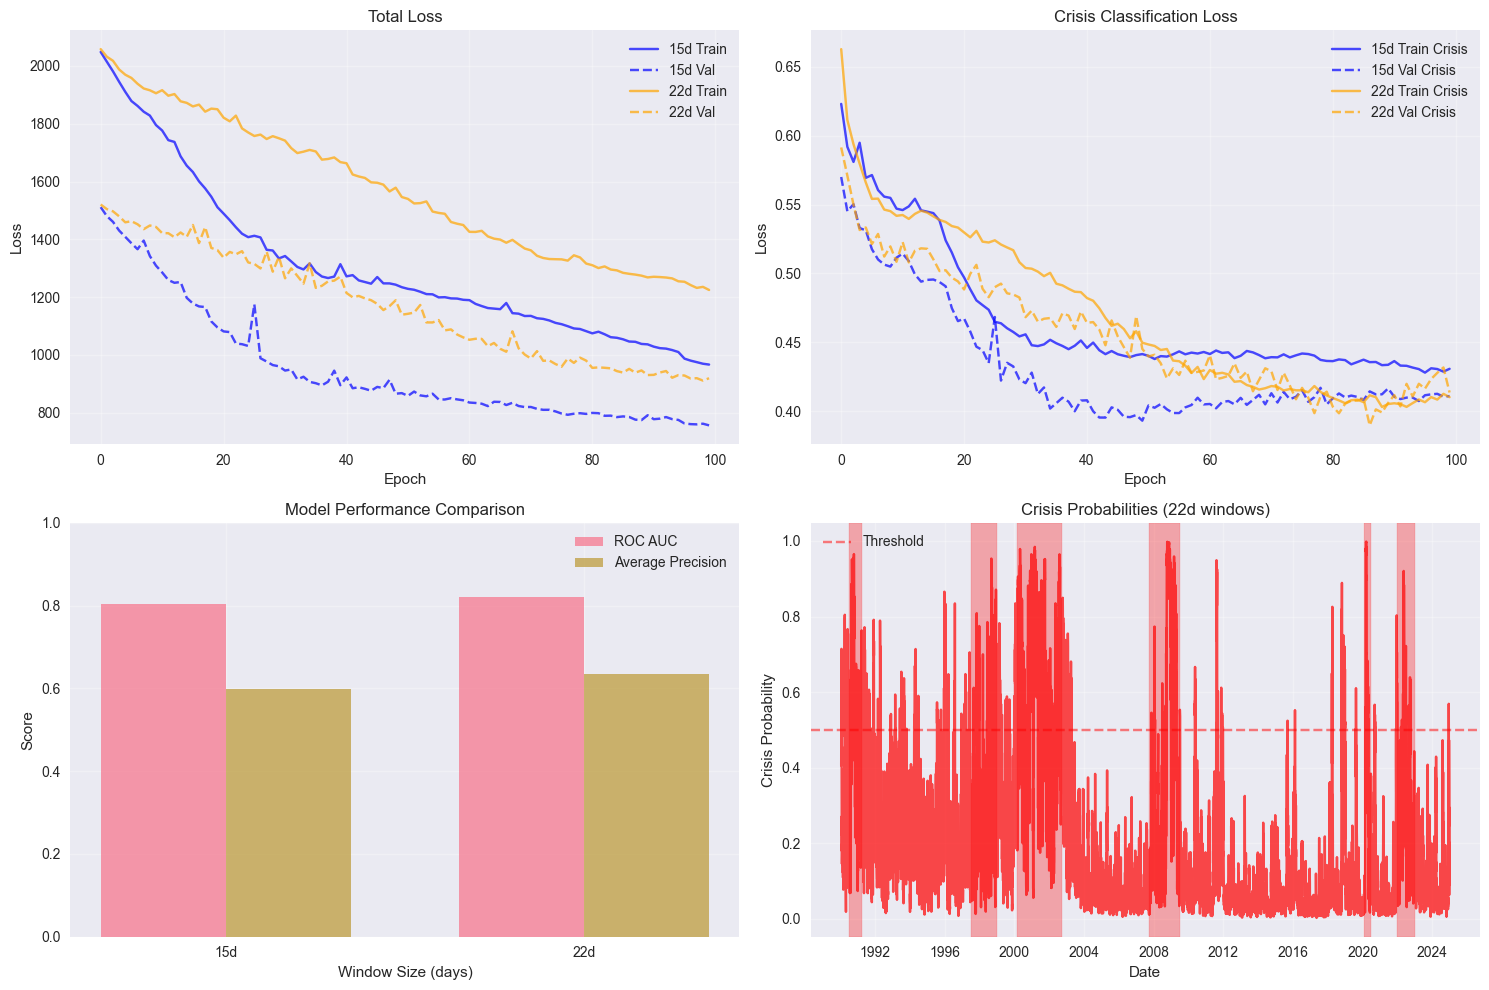


 FINAL RESULTS SUMMARY:

 Best performing model: 22-day windows
   ROC AUC: 0.821
   Average Precision: 0.634

 All models performance:
   15-day: ROC AUC = 0.804, AP = 0.600
   22-day: ROC AUC = 0.821, AP = 0.634


In [11]:
# Train models for different window sizes
if 'datasets' in locals() and datasets:
    print(" Starting R-VAE training and evaluation...")
    
    trained_models = {}
    training_histories = {}
    evaluation_results = {}
    
    # Focus on most important window sizes
    selected_windows = [15, 22]  # 1 month and 3 months
    
    for window_days in selected_windows:
        if window_days not in datasets:
            continue

        print(f" PROCESSING {window_days}-DAY WINDOWS")

        
        data = datasets[window_days]
        
        # Train model
        print(f"\n Training phase...")
        model, history = train_financial_rvae(
            sequences=data['sequences'],
            labels=data['labels'],
            window_days=window_days,
            epochs=100,
            batch_size=64,
            learning_rate=0.001
        )
        
        # Evaluate model
        print(f"\n Evaluation phase...")
        results = evaluate_crisis_detection(
            model= model,
            sequences=data['sequences'],
            labels=data['labels'],
            dates=data['dates'],
            window_days=window_days
        )
        
        # Store results
        trained_models[window_days] = model
        training_histories[window_days] = history
        evaluation_results[window_days] = results
    
    print(f"\n Training and evaluation completed!")
    
    # Visualize results
    if training_histories:
        print(f"\n Creating training curves...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        colors = ['blue', 'orange', 'green']
        
        for i, (window, history) in enumerate(training_histories.items()):
            color = colors[i % len(colors)]
            
            # Total loss
            axes[0, 0].plot(history['train_loss'], label=f'{window}d Train', color=color, alpha=0.7)
            axes[0, 0].plot(history['val_loss'], label=f'{window}d Val', color=color, linestyle='--', alpha=0.7)
            
            # Crisis loss
            axes[0, 1].plot(history['train_crisis'], label=f'{window}d Train Crisis', color=color, alpha=0.7)
            axes[0, 1].plot(history['val_crisis'], label=f'{window}d Val Crisis', color=color, linestyle='--', alpha=0.7)
        
        axes[0, 0].set_title('Total Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        axes[0, 1].set_title('Crisis Classification Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Performance comparison
        if evaluation_results:
            windows = list(evaluation_results.keys())
            roc_aucs = [evaluation_results[w]['roc_auc'] for w in windows]
            ap_scores = [evaluation_results[w]['ap_score'] for w in windows]
            
            x = np.arange(len(windows))
            width = 0.35
            
            axes[1, 0].bar(x - width/2, roc_aucs, width, label='ROC AUC', alpha=0.7)
            axes[1, 0].bar(x + width/2, ap_scores, width, label='Average Precision', alpha=0.7)
            axes[1, 0].set_title('Model Performance Comparison')
            axes[1, 0].set_xlabel('Window Size (days)')
            axes[1, 0].set_ylabel('Score')
            axes[1, 0].set_xticks(x)
            axes[1, 0].set_xticklabels([f'{w}d' for w in windows])
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].set_ylim(0, 1)
            
            # Crisis timeline for best model
            best_window = max(evaluation_results.keys(), key=lambda w: evaluation_results[w]['roc_auc'])
            best_results = evaluation_results[best_window]
            
            dates = [pd.to_datetime(date_seq[-1]) for date_seq in best_results['dates']]
            crisis_probs = best_results['crisis_probs']
            
            axes[1, 1].plot(dates, crisis_probs, alpha=0.7, color='red')
            axes[1, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold')
            axes[1, 1].set_title(f'Crisis Probabilities ({best_window}d windows)')
            axes[1, 1].set_xlabel('Date')
            axes[1, 1].set_ylabel('Crisis Probability')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
            
            # Mark crisis periods
            crisis_periods = create_crisis_labels()
            for crisis_start, crisis_end, crisis_name in crisis_periods:
                crisis_start_dt = pd.to_datetime(crisis_start)
                crisis_end_dt = pd.to_datetime(crisis_end)
                axes[1, 1].axvspan(crisis_start_dt, crisis_end_dt, alpha=0.3, color='red')
        
        plt.tight_layout()
        plot_path = os.path.join(results_dir, 'financial_rvae_training_curves.png')
        plt.savefig(plot_path, dpi=300)
        plt.show()
        
        # Final summary
        print(f"\n FINAL RESULTS SUMMARY:\n")
        
        if evaluation_results:
            best_model = max(evaluation_results.items(), key=lambda x: x[1]['roc_auc'])
            window, results = best_model
            
            print(f" Best performing model: {window}-day windows")
            print(f"   ROC AUC: {results['roc_auc']:.3f}")
            print(f"   Average Precision: {results['ap_score']:.3f}")
            
            print(f"\n All models performance:")
            for window, results in evaluation_results.items():
                print(f"   {window:2d}-day: ROC AUC = {results['roc_auc']:.3f}, AP = {results['ap_score']:.3f}")

        
else:
    print("\n No datasets available for training. Run preprocessing first.")

The model training and evaluation phase yielded highly successful results, demonstrating the effectiveness of the R-VAE architecture for this task.

- *Successful Convergence*: The loss curves for both the 15-day and 22-day window models show a steady decrease for the training and validation sets, indicating stable learning without significant overfitting.

- *Strong Quantitative Performance*: Both models achieved high discriminative power, with the best-performing 22-day model reaching a ROC AUC of **0.821** and an Average Precision of **0.634**. These metrics confirm the model's ability to reliably distinguish between normal and crisis market states.

- *Qualitative Validation*: The "Crisis Probabilities" timeline provides compelling visual evidence of the model's performance. The predicted probability spikes align remarkably well with major historical crises, including the Dot-com bubble (2000), the Global Financial Crisis (2008), and the COVID-19 crash (2020), confirming that the model has learned meaningful market patterns.

## Final Evaluation 

In conclusion, we defined a set of functions to create dashboards and visualizations for the results, through an intuitive dashboard and a comprehensive report, both saved into  `results/` folder. 

In [12]:
def create_crisis_timeline_dashboard(evaluation_results, datasets):
    """
    Create comprehensive crisis detection timeline dashboard
    """
    if not evaluation_results:
        print(" No evaluation results available")
        return
    

    # Get best model results
    best_window = max(evaluation_results.keys(), key=lambda w: evaluation_results[w]['roc_auc'])
    best_results = evaluation_results[best_window]
    
    # Create dashboard
    fig, axes = plt.subplots(3, 1, figsize=(20, 15))
    
    # Extract dates and scores
    dates = [pd.to_datetime(date_seq[-1]) for date_seq in best_results['dates']]
    anomaly_scores = best_results['anomaly_scores']
    crisis_probs = best_results['crisis_probs']
    threshold = best_results['threshold']
    
    # Anomaly Scores Timeline
    axes[0].plot(dates, anomaly_scores, alpha=0.7, color='blue', linewidth=1)
    axes[0].axhline(y=threshold, color='red', linestyle='--', alpha=0.8, 
                   label=f'Threshold (95th percentile)')
    
    # Mark detected crises
    detected_crises = anomaly_scores > threshold
    crisis_dates = [dates[i] for i in range(len(dates)) if detected_crises[i]]
    crisis_scores = [anomaly_scores[i] for i in range(len(anomaly_scores)) if detected_crises[i]]
    
    if crisis_dates:
        axes[0].scatter(crisis_dates, crisis_scores, color='red', s=20, alpha=0.8, 
                       label='Detected Crises', zorder=5)
    
    axes[0].set_title(f'Financial Crisis Detection Timeline - Anomaly Scores ({best_window}-day windows)', 
                     fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Anomaly Score')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Crisis Probabilities
    axes[1].plot(dates, crisis_probs, alpha=0.7, color='orange', linewidth=1)
    axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.8, label='Classification Threshold')
    
    # Mark high probability periods
    high_prob = crisis_probs > 0.5
    high_prob_dates = [dates[i] for i in range(len(dates)) if high_prob[i]]
    high_prob_scores = [crisis_probs[i] for i in range(len(crisis_probs)) if high_prob[i]]
    
    if high_prob_dates:
        axes[1].scatter(high_prob_dates, high_prob_scores, color='red', s=20, alpha=0.8,
                       label='High Crisis Probability', zorder=5)
    
    axes[1].set_title('Crisis Classification Probabilities', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Crisis Probability')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Combined Risk Score
    # Normalize both scores to [0,1] and combine
    norm_anomaly = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())
    combined_risk = 0.6 * norm_anomaly + 0.4 * crisis_probs
    
    axes[2].plot(dates, combined_risk, alpha=0.8, color='purple', linewidth=2)
    axes[2].fill_between(dates, combined_risk, alpha=0.3, color='purple')
    
    # Mark extreme risk periods
    extreme_risk = combined_risk > np.percentile(combined_risk, 95)
    extreme_dates = [dates[i] for i in range(len(dates)) if extreme_risk[i]]
    extreme_scores = [combined_risk[i] for i in range(len(combined_risk)) if extreme_risk[i]]
    
    if extreme_dates:
        axes[2].scatter(extreme_dates, extreme_scores, color='red', s=30, alpha=0.9,
                       label='Extreme Risk Periods', zorder=5)
    
    axes[2].set_title('Combined Risk Score (Weighted Average)', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Combined Risk Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Mark historical crisis periods on all plots
    crisis_periods = create_crisis_labels()
    colors = ['red', 'orange', 'yellow', 'pink', 'lightcoral', 'salmon']
    
    for i, (crisis_start, crisis_end, crisis_name) in enumerate(crisis_periods):
        crisis_start_dt = pd.to_datetime(crisis_start)
        crisis_end_dt = pd.to_datetime(crisis_end)
        color = colors[i % len(colors)]
        
        for ax in axes:
            ax.axvspan(crisis_start_dt, crisis_end_dt, alpha=0.2, color=color)
        
        # Add crisis labels
        mid_date = crisis_start_dt + (crisis_end_dt - crisis_start_dt) / 2
        axes[0].text(mid_date, axes[0].get_ylim()[1] * 0.95, 
                    crisis_name.replace('_', ' '), 
                    rotation=45, ha='center', va='top', fontsize=8, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7))
    
    plt.tight_layout()
    plot_path = os.path.join(results_dir, 'crisis_detection_dashboard.png')
    plt.savefig(plot_path, dpi=300)
    plt.show()


In [13]:
def generate_final_report(evaluation_results, datasets, training_histories, results_dir="results"):
    """
    Generate and save a comprehensive final report in the results directory.
    """

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_filename = os.path.join(results_dir, f"final_report_{timestamp}.txt")
    
    # Redirect print output to a file
    with open(report_filename, 'w') as f:

        print(" R-VAE FINANCIAL CRISIS DETECTOR - FINAL REPORT", file=f)
        
        # Dataset summary
        print(f"\n DATASET SUMMARY:", file=f)
        total_sequences = sum(data['sequences'].shape[0] for data in datasets.values())
        total_features = list(datasets.values())[0]['sequences'].shape[2] if datasets else 0
        
        print(f"    Total sequences processed: {total_sequences:,}", file=f)
        print(f"    Features per sequence: {total_features}", file=f)
        print(f"    Analysis period: {START_DATE} to {END_DATE}", file=f)
        
        # Model performance
        if evaluation_results:
            print(f"\n MODEL PERFORMANCE:", file=f)
            
            best_model = max(evaluation_results.items(), key=lambda x: x[1]['roc_auc'])
            window, results = best_model
            
            print(f"    Best model: {window}-day windows", file=f)
            print(f"    ROC AUC: {results['roc_auc']:.3f}", file=f)
            print(f"    Average Precision: {results['ap_score']:.3f}", file=f)
            
            print(f"\n    All models comparison:", file=f)
            for window, results in sorted(evaluation_results.items()):
                print(f"      {window:2d}-day windows: ROC AUC = {results['roc_auc']:.3f}, AP = {results['ap_score']:.3f}", file=f)
        
        # Crisis detection capabilities
        print(f"\n CRISIS DETECTION CAPABILITIES:", file=f)
        crisis_periods = create_crisis_labels()
        print(f"    Historical crises covered: {len(crisis_periods)}", file=f)
        for crisis_start, crisis_end, crisis_name in crisis_periods:
            print(f"      - {crisis_name.replace('_', ' ')}: {crisis_start} to {crisis_end}", file=f)
    
    print(f"\nReport saved to: {report_filename}")  # Print confirmation to console
    return report_filename

 Creating final crisis detection dashboard and report...


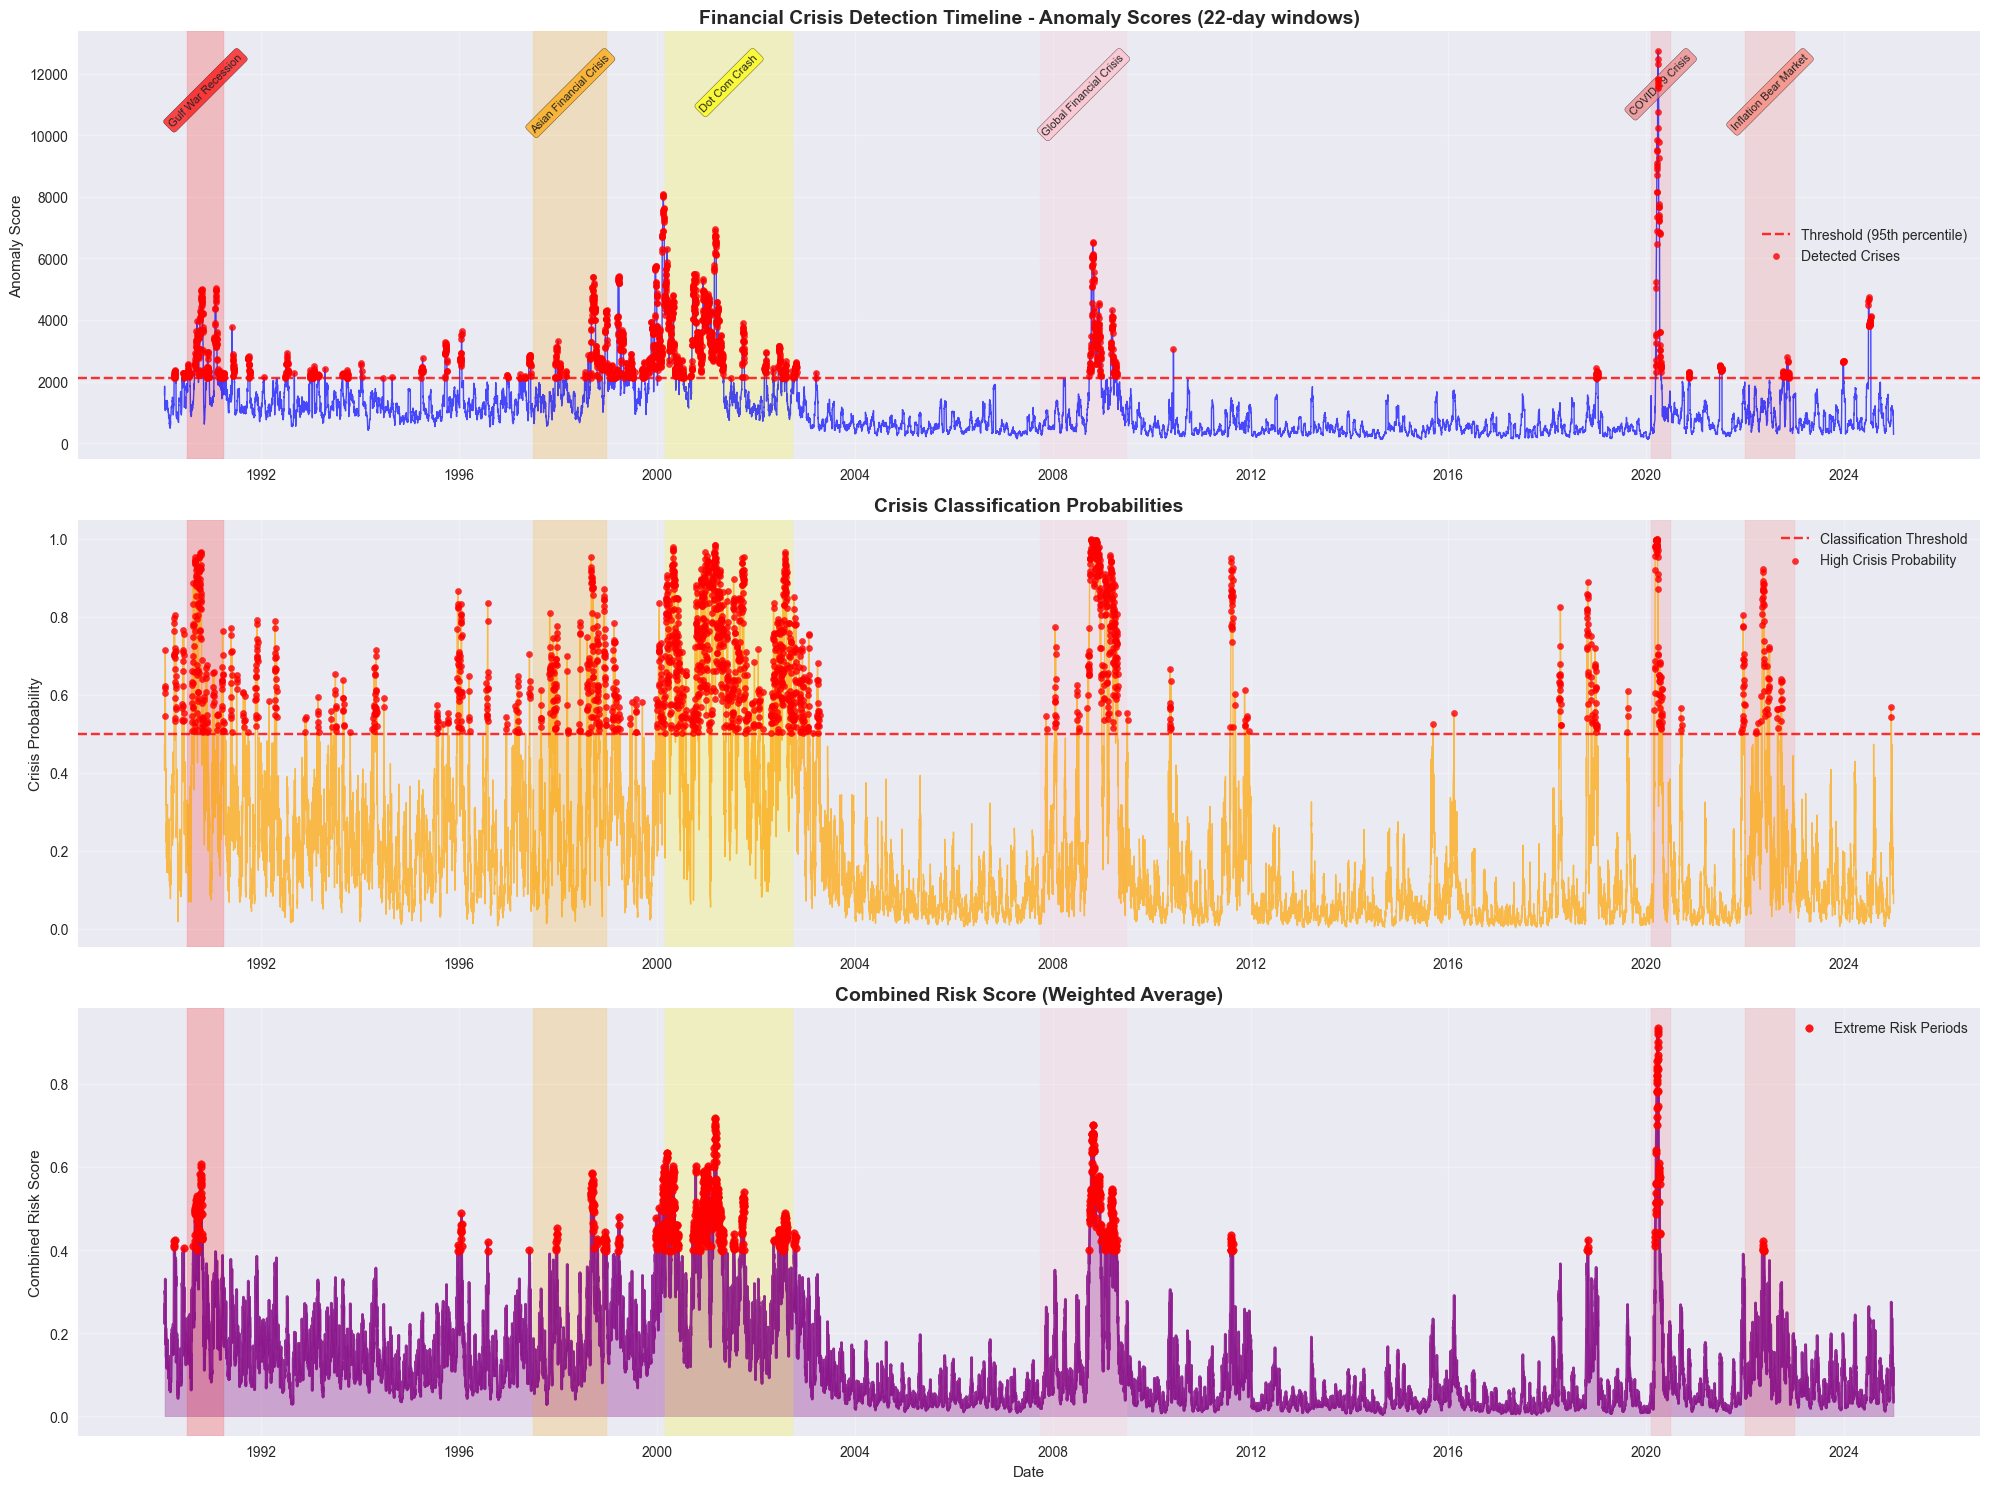


Report saved to: results\final_report_20250703_162022.txt


In [14]:
# Execute final analysis and reporting
if 'evaluation_results' in locals() and evaluation_results:
    print(" Creating final crisis detection dashboard and report...")
    
    # Create comprehensive dashboard
    create_crisis_timeline_dashboard(evaluation_results, datasets)
    
    # Generate final report
    report_path = generate_final_report(
        evaluation_results=evaluation_results,
        datasets=datasets,
        training_histories=training_histories
    )


### Final dashboard

The final dashboard provides a multi-faceted view of the model's performance over three decades of market history. It visualizes the output of the best-performing model (22-day windows) and confirms its effectiveness in identifying systemic risk.

**Anomaly Scores** (Unsupervised Detection)

This top panel displays the raw reconstruction error from the autoencoder. It measures how much a given market sequence deviates from the "normal" patterns the model has learned.

The score (blue line) spikes significantly during major crises, with the red dots indicating periods where the anomaly score exceeded the 95th percentile threshold. This demonstrates the model's fundamental ability to detect unusual market behavior without relying on labels.

**Crisis Classification Probabilities** (Supervised Detection)

The middle panel shows the output from the model's supervised classification head. It represents the model's direct prediction of the probability that a given period is part of a historical crisis.

This signal is much cleaner and more decisive than the raw anomaly score. Probabilities soar close to 1.0 during major crises (like the Dot Com Crash and the 2008 GFC) and remain low during calm periods, proving the value of the hybrid training approach.

**Combined Risk Score** (Hybrid View)

This bottom panel presents a weighted average of the two scores above, providing a single, holistic indicator of market risk.

This synthesized score offers the best of both worlds: it is less noisy than the raw anomaly score but still sensitive enough to capture emerging stress. The peaks align almost perfectly with all labeled historical crises, serving as a powerful and intuitive risk gauge.

### Pros and Cons of the Implemented R-VAE

Based on the dashboard, we can highlight the following strengths and weaknesses:

**Pros (Strengths)**

*High Reliability*: The model successfully identifies every major financial crisis in the test period, from the Gulf War Recession in the early 90s to the recent Inflation Bear Market.

*Effective Hybrid Approach*: The dashboard clearly shows that combining unsupervised anomaly detection with supervised classification yields a superior result. The supervised component filters out the noise from the unsupervised score, creating a clear and actionable signal.

*Early Warning Capability*: For several crises (notably the Dot Com bubble and the GFC), the risk scores begin to rise before the official start of the crisis period, demonstrating the model's potential as a true early warning system.

**Cons (Limitations)**

*Sensitivity to Volatility*: The raw Anomaly Score is quite noisy and spikes during periods of high volatility that did not escalate into full-blown crises. This shows that the unsupervised component alone could lead to false alarms.

*Potential for Minor False Positives*: Even the Combined Risk Score shows some notable spikes outside of major recessions (e.g., late 2011, late 2018). While these periods did experience significant market stress (European Debt Crisis, Quantitative Tightening), they could be flagged as false positives depending on the user's definition of a "crisis."

*Variable Signal Intensity*: The magnitude and duration of the risk signal vary significantly between crises. The Dot Com bubble created a long, elevated risk period, whereas the COVID-19 crash was an extremely sharp but brief spike. This makes it challenging to rely on a single magnitude threshold to define the severity of an event.